# Model to find the best location for a new well of OilyGiant mining company

Based of data on oil samples from three regions, I will pick the top 200 wells with the largest predicted volume of reserves. I will build a linear model that will help to pick the region with the highest profit margin and risk lower then 2.5%. Analyzing the data using the Bootstrapping technique.

## Downloading and Preparing Data

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None

In [2]:
try:
    geo_data_0 = pd.read_csv('geo_data_0.csv')
    geo_data_1 = pd.read_csv('geo_data_1.csv')
    geo_data_2 = pd.read_csv('geo_data_2.csv')
except:
    geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')
    
display(geo_data_0.sample(),geo_data_0.shape,\
        geo_data_1.sample(),geo_data_1.shape,\
        geo_data_2.sample(), geo_data_2.shape)

,id,f0,f1,f2,product
47104,qRnls,0.198187,-0.196172,2.469499,50.127507


(100000, 5)

,id,f0,f1,f2,product
88242,NDO9q,-9.627893,-14.305292,5.005301,137.945408


(100000, 5)

,id,f0,f1,f2,product
5603,UZEPj,-1.300679,-0.13935,6.901773,137.150007


(100000, 5)

In [3]:
print(geo_data_0.isnull().sum().sum())
print()
print(geo_data_1.isnull().sum().sum())
print()
print(geo_data_2.isnull().sum().sum())

0

0

0


In [4]:
print(geo_data_0.duplicated().sum())
print()
print(geo_data_1.duplicated().sum())
print()
print(geo_data_2.duplicated().sum())

0

0

0


There are no missing values or duplicated rows. I will combine the data sets to one data frame in order to be able to calculate metrics per region easier.

In [5]:
geo_data = pd.concat([geo_data_0, geo_data_1, geo_data_2], keys=['g0', 'g1', 'g2']).reset_index()
geo_data.describe(include='all')

,level_0,level_1,id,f0,f1,f2,product
count,300000,300000.000000,300000,300000.000000,300000.000000,300000.000000,300000.000000
unique,3,NaN,299951,NaN,NaN,NaN,NaN
top,g0,NaN,uSye4,NaN,NaN,NaN,NaN
freq,100000,NaN,2,NaN,NaN,NaN,NaN
mean,NaN,49999.500000,NaN,0.547913,-1.516172,2.497439,85.441667
std,NaN,28867.561571,NaN,5.316634,3.900220,2.916502,46.519494
min,NaN,0.000000,NaN,-31.609576,-26.358598,-12.088328,0.000000
25%,NaN,24999.750000,NaN,-1.003037,-2.478939,0.648213,52.666629
50%,NaN,49999.500000,NaN,0.347934,-0.229632,2.491215,84.038886
75%,NaN,74999.250000,NaN,1.755365,0.678562,4.344943,124.174086


The model I am working with is linear regression, the categories have to be encoded in a way that assigns equal importance to all of them, yet still lets them be recognized as distinct and different. 

The features in this data are numerical (besides `id` but I will drop this feature because it is a unique object used to track the data entry and does not have an impact on our target). For this reason I will prepare the data with feature scaling only.

### Feature Scaling and Model inisialization, training, and testing

In [6]:
count = 0
for region in ['g0', 'g1', 'g2']:
    df = geo_data.query('level_0 == @region').drop(['id', 'level_0', 'level_1'], axis=1).reset_index()
    
    features = df.drop('product', axis=1)
    target = df['product']
    
    features_train, features_valid,  target_train, target_valid = train_test_split(
    features, target, test_size=0.25 , random_state=12345)
    
    numeric = ['f0','f1','f2']
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    
    if count == 0:
        features_train_0 = features_train
        target_train_0 = target_train
        features_valid_0 = features_valid
        target_valid_0 = target_valid
    elif count == 1:
        features_train_1 = features_train
        target_train_1 = target_train
        features_valid_1 = features_valid
        target_valid_1 = target_valid
    elif count == 2:
        features_train_2 = features_train
        target_train_2 = target_train
        features_valid_2 = features_valid
        target_valid_2 = target_valid
    
    count += 1  

print('Features shape:')
print('geo_data_0:', 'train:', features_train_0.shape, 'validation:',features_valid_0.shape)
print('geo_data_1:','train:', features_train_1.shape, 'validation:',features_valid_1.shape)
print('geo_data_2:','train:', features_train_2.shape, 'validation:',features_valid_2.shape)
print()
print('Target shape:')
print('geo_data_0:','train:',target_train_0.shape, 'validation:',target_valid_0.shape)
print('geo_data_1:','train:',target_train_1.shape, 'validation:',target_valid_1.shape)
print('geo_data_2:','train:',target_train_2.shape, 'validation:',target_valid_2.shape)    

Features shape:
geo_data_0: train: (75000, 4) validation: (25000, 4)
geo_data_1: train: (75000, 4) validation: (25000, 4)
geo_data_2: train: (75000, 4) validation: (25000, 4)

Target shape:
geo_data_0: train: (75000,) validation: (25000,)
geo_data_1: train: (75000,) validation: (25000,)
geo_data_2: train: (75000,) validation: (25000,)


In [7]:
print()
model_0 = LinearRegression()
model_0.fit(features_train_0, target_train_0)
predicted_valid_0 = model_0.predict(features_valid_0)
mse_0 = mean_squared_error(target_valid_0, predicted_valid_0)
print('geo_data_0')
print('AVG_0 =', predicted_valid_0.mean())
print('RMSE_0 =', mse_0 ** 0.5)
print()
model_1 = LinearRegression()
model_1.fit(features_train_1, target_train_1)
predicted_valid_1 = model_1.predict(features_valid_1)
mse_1 = mean_squared_error(target_valid_1, predicted_valid_1)
print('geo_data_1')
print('AVG_1 =', predicted_valid_1.mean())
print('RMSE_1 =', mse_1 ** 0.5)
print()
model_2 = LinearRegression()
model_2.fit(features_train_2, target_train_2)
predicted_valid_2 = model_2.predict(features_valid_2)
mse_2 = mean_squared_error(target_valid_2, predicted_valid_2)
print('geo_data_2')
print('AVG_2 =', predicted_valid_2.mean())
print('RMSE_2 =', mse_2 ** 0.5)


geo_data_0
AVG_0 = 92.5924422447677
RMSE_0 = 37.57949193854287

geo_data_1
AVG_1 = 68.72849982676499
RMSE_1 = 0.8930659052624615

geo_data_2
AVG_2 = 94.96522806981984
RMSE_2 = 40.03003812272811


The models have been trained and tested per region. 
Region 2 has the largest volume of predicted oil reserves, followed by region 0, then far behind is region 1 with the least average reserves.
Region 1 though has the lowest RMSE score (the model is best fitted to this regions data), following far behind are regions 0 and 2 with the highest RMSE scores (the models are not fitted to the data as well).
This pattern is confirmed with the cross-validation scores- region 1 has the highest score (close to 1) and then region 0 and region 2, this is indicative of their models prediction accuracy recpectivly.

These results of high volume predictions and high rate of error can be investigated further by examening the features distribution and correlations.

## Profit Calculation

In [8]:
num_wells = 200
budget = 100*(10**6)
budget_per_well = budget / num_wells

revenue_per_barrel = 4.5
revenue_per_unit = 4500

min_risk = 0.025

In [9]:
min_reserve_vol = budget_per_well/revenue_per_unit
print('in order to develop a new well without losses, the reserves must have', round(min_reserve_vol,2), 'thousand barrels')
print()
print('the average volume of predicted reserves in each region (thousand barrels):')
print()
for region in ['g0', 'g1', 'g2']:
    if region == 'g0':
        pred = predicted_valid_0
    elif region == 'g1':
        pred = predicted_valid_1   
    elif region == 'g2':
        pred = predicted_valid_2  
    print(region, 'region:', round(pred.mean(),2))

in order to develop a new well without losses, the reserves must have 111.11 thousand barrels

the average volume of predicted reserves in each region (thousand barrels):

g0 region: 92.59
g1 region: 68.73
g2 region: 94.97


All of the regions have predicted volume of oil on average smaller then the break even minimum amount.

In [15]:
#function to calculate profit from a set of selected oil wells and model predictions per region

def profit(region, target, predictions):
    pred_sorted = predictions.reset_index().sort_values(by=0,ascending=False)
    selected = target.reset_index().loc[pred_sorted[:200].index]
    
    return sum(revenue_per_unit*selected['product'])-budget

In [16]:
for region in ['g0', 'g1', 'g2']:
    if region == 'g0':
        target = target_valid_0.reset_index()
        predictions = predicted_valid_0
    elif region == 'g1':
        target = target_valid_1.reset_index()
        predictions = predicted_valid_1   
    elif region == 'g2':
        target = target_valid_2.reset_index()
        predictions = predicted_valid_2  
    predictions = pd.Series(predictions)
    print(region, 'profit:')
    print(round(profit(region, target, predictions),2), 'USD')
    print()

g0 profit:
33208260.43 USD

g1 profit:
24150866.97 USD

g2 profit:
26887004.6 USD



Region 0 has the highest overall profit for the best predicted wells, then region 2 and region 1, while region 2 is closer to region 1 then it is to region 0.

In [17]:
# bootstrapping with 1000 samples to find the distribution of profit per region

state = np.random.RandomState(39)  
revenue = []

for region in ['g0', 'g1', 'g2']:  
    if region == 'g0':
        target = target_valid_0.reset_index()
        predictions = predicted_valid_0
    elif region == 'g1':
        target = target_valid_1.reset_index()
        predictions = predicted_valid_1   
    elif region == 'g2':
        target = target_valid_2.reset_index()
        predictions = predicted_valid_2  
    predictions = pd.Series(predictions)
    revenue_= []
    for i in range(1000):
        target_subsample = target.sample(n=500, replace=True, random_state=state)
        pred_subsample = predictions.iloc[target_subsample.index]
        revenue_.append(profit(region, target_subsample, pred_subsample))
        
    revenue.append(revenue_)
revenue_0 = pd.Series(revenue[0])
revenue_1 = pd.Series(revenue[1])
revenue_2 = pd.Series(revenue[2])

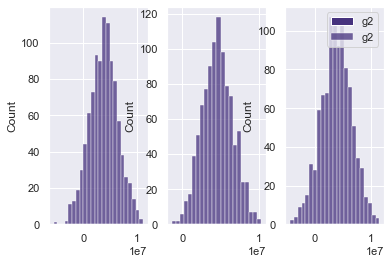

In [18]:
sns.set(palette='viridis') 
fig, axes = plt.subplots(1, 3)
sns.histplot(revenue_0, label='g0', ax=axes[0])
sns.histplot(revenue_1, label='g1', ax=axes[1])
sns.histplot(revenue_2, label='g2', ax=axes[2])
plt.legend()
plt.show()

<AxesSubplot:ylabel='Count'>

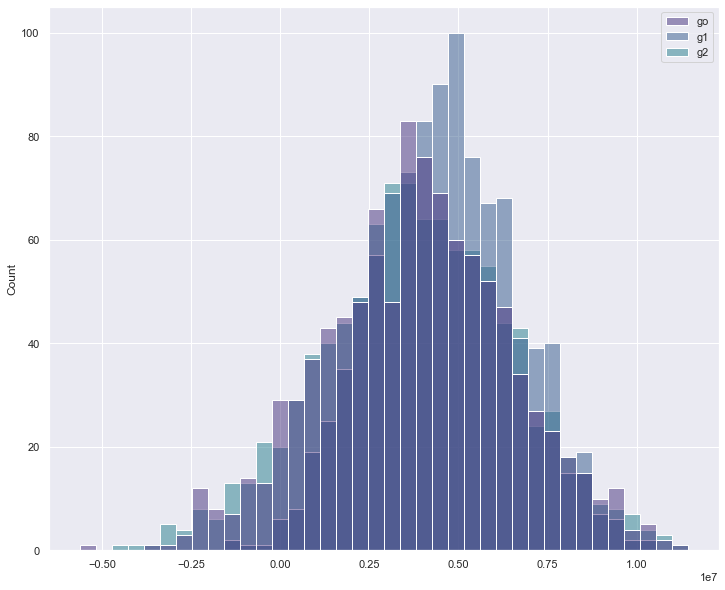

In [19]:
plt.figure(figsize=(12,10))
sns.histplot({'go':revenue_0, 'g1':revenue_1, 'g2': revenue_2})

All the regions profit are distributed mostly between 0 and 10 million.
Region 0 has the most left skewed distribution of profit- This distribution has the most negative values.
Region 1 has the most rightly skewed distribution- This distributiom has the least negative values. region 1 also has a high peak around the mean value.
Region 2 has distribution closests to normal distribution- This distribution has a medium amount of negative values.

Based on the profit distribution I would pick region 2 or region 1 for development because thier profit distribution shows more profitable wells. Previouce results have shown that region 2 has more oil in its reserves then region 1. For this reason, based off of amount of profit, I would pick region 2 for development.

In [20]:
print(region, 'profit per well:')
print(round(profit(region, target_valid_2.reset_index(), pd.Series(predicted_valid_2))/200, 2), 'USD')

g2 profit per well:
134435.02 USD


### risks and profit per region

In [21]:
for region in ['g0', 'g1', 'g2']:
    if region == 'g0':
        prof = revenue_0
    elif region == 'g1':
        prof = revenue_1
    elif region == 'g2':
        prof = revenue_2
    print(region)
    lower = prof.quantile(0.025)
    higher = prof.quantile(0.975)
    mean = prof.mean()
    print('Average profit:', round(mean,2), 'USD')
    print('95% confidence interval:', '[', round(lower,2),',' ,round(higher,2), '] USD')
    loss = sum(prof<0)
    prob = loss/len(prof)
    print('risk of losses:', (prob*100), '%')
    print()
    print('♡♡♡')
    print()

g0
Average profit: 3836924.25 USD
95% confidence interval: [ -1611571.97 , 8983418.17 ] USD
risk of losses: 7.6 %

♡♡♡

g1
Average profit: 4617191.61 USD
95% confidence interval: [ 837840.8 , 8508230.93 ] USD
risk of losses: 0.8 %

♡♡♡

g2
Average profit: 3808253.63 USD
95% confidence interval: [ -1744232.65 , 9135570.86 ] USD
risk of losses: 8.3 %

♡♡♡



The best region for development is region 1 because it has the highest average profit and lowest risk of losses, region 1 has 0.3% risk of loss, this is the only region with risk below 2.5% not including. 
This outcome is aligned with the previouce results, region 1 shown the least amount of negative values when examening the distribution of profit.

# Conclusion

Region 0 has the most oil in its reserves but the risk of losses is on the maximum threshold.

Region 1 has the least oil in its reserves but the lowest risk and thus highest profit, the model is very accurate for its data so this should be the development region.

Region 2 has substancial oil in its reserve but the risk of losses is the highest and the model is the least accurate for its data.


It could be beneficial to analyze the distribution of oil reserves per region and the features dispersionand corrolation, in order to improve the models quality for regions 2 and 0. This could lead to lower risk of losses in these regions and make development more secure and profitable.